In [26]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score


In [28]:
# Load the dataset
data = pd.read_csv('data.csv', delimiter=';')

# Display first few rows
print(data.head())

# Check for missing values and basic statistics
print(data.info())
print(data.describe())


   Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3                             1                       1   
4                             0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                         

In [30]:
# removing 'enrolled' for the sake of this project as it wont be an accurate addition to the study

# Strip whitespace and convert to lowercase to standardize values in 'Target'
data['Target'] = data['Target'].str.strip().str.capitalize()

# Verify unique values in 'Target' after cleaning
print("Unique values in 'Target' after cleaning:", data['Target'].unique())

# Exclude rows where 'Target' is 'Enrolled'
data = data[data['Target'].isin(['Graduate', 'Dropout'])]

# Verify the updated distribution in 'Target'
print("Value counts in 'Target' after filtering:")
print(data['Target'].value_counts())

Unique values in 'Target' after cleaning: ['Dropout' 'Graduate' 'Enrolled']
Value counts in 'Target' after filtering:
Target
Graduate    2209
Dropout     1421
Name: count, dtype: int64


In [32]:
# Some feature engineering to help with results
# Calculate overall average grade for both semesters
data['average_grade'] = (data['Curricular units 1st sem (grade)'] + 
                         data['Curricular units 2nd sem (grade)']) / 2

# Indicator: High unemployment and inflation impact on students
data['high_unemployment'] = (data['Unemployment rate'] > data['Unemployment rate'].median()).astype(int)
data['high_inflation'] = (data['Inflation rate'] > data['Inflation rate'].median()).astype(int)


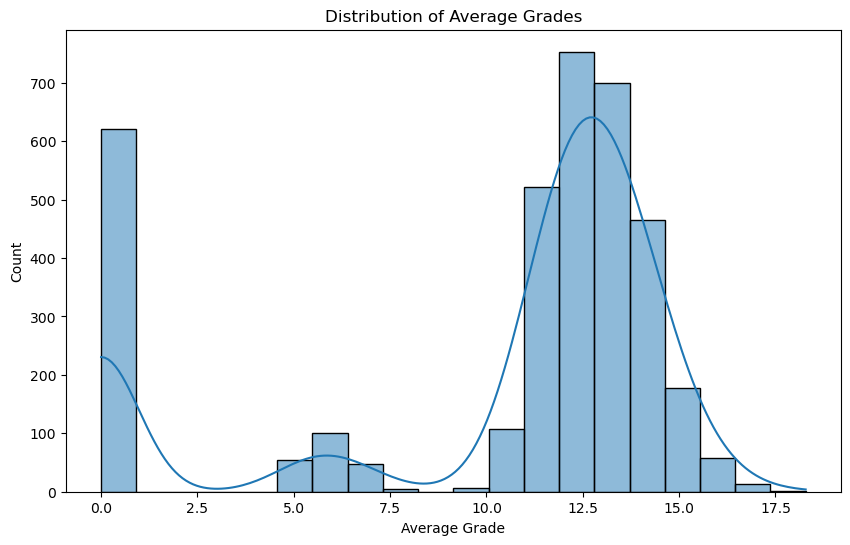

In [34]:
# EDA

#Histogram

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data['average_grade'], bins=20, kde=True)
plt.title('Distribution of Average Grades')
plt.xlabel('Average Grade')
plt.show()


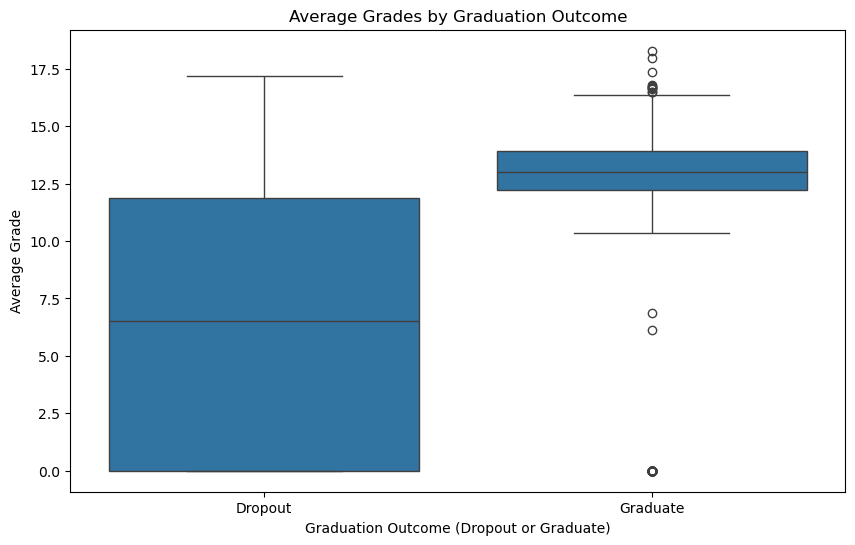

In [36]:
# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Target', y='average_grade', data=data)
plt.title('Average Grades by Graduation Outcome')
plt.xlabel('Graduation Outcome (Dropout or Graduate)')
plt.ylabel('Average Grade')
plt.show()


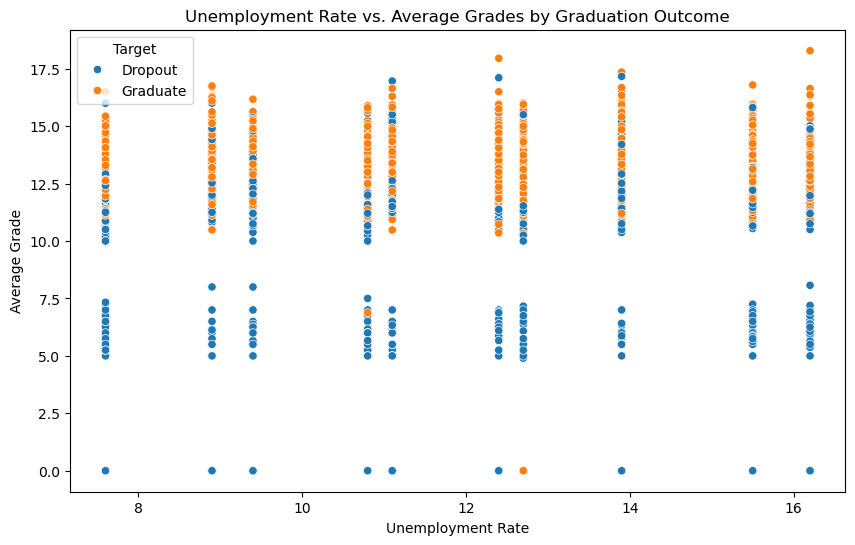

In [38]:
# Scatter Plot of Unemployment Rate vs. Average Grades 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Unemployment rate', y='average_grade', hue='Target', data=data)
plt.title('Unemployment Rate vs. Average Grades by Graduation Outcome')
plt.xlabel('Unemployment Rate')
plt.ylabel('Average Grade')
plt.show()


In [40]:
# Model Building

# Data prep for the model

# Encode target variable (Graduate = 1, Dropout = 0)
data['Target'] = data['Target'].map({'Graduate': 1, 'Dropout': 0})

# Define features and target
X = data[['average_grade', 'Unemployment rate', 'Inflation rate', 'high_unemployment',
          'high_inflation']]
y = data['Target']

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
# Double-check the value counts in 'y' to confirm the distribution of 0s and 1s
print(y.value_counts())

# Check the unique values in 'y'
print("Unique values in 'y':", y.unique())

# Check again for NaN values in 'Target' after all preprocessing steps
print("NaN values in 'Target':", y.isnull().sum())

# Display unique values in 'Target' to check for any unexpected entries
print(data['Target'].unique())


Target
1    2209
0    1421
Name: count, dtype: int64
Unique values in 'y': [0 1]
NaN values in 'Target': 0
[0 1]


In [44]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Initialize and train the logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = log_reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])

print(f"Logistic Regression - Accuracy: {accuracy:.2f}, ROC-AUC: {roc_auc:.2f}")
print(classification_report(y_test, y_pred))



Logistic Regression - Accuracy: 0.79, ROC-AUC: 0.83
              precision    recall  f1-score   support

           0       0.92      0.51      0.65       277
           1       0.76      0.97      0.85       449

    accuracy                           0.79       726
   macro avg       0.84      0.74      0.75       726
weighted avg       0.82      0.79      0.78       726



In [46]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])

print(f"Random Forest - Accuracy: {accuracy_rf:.2f}, ROC-AUC: {roc_auc_rf:.2f}")
print(classification_report(y_test, y_pred_rf))



Random Forest - Accuracy: 0.74, ROC-AUC: 0.80
              precision    recall  f1-score   support

           0       0.65      0.68      0.66       277
           1       0.80      0.78      0.79       449

    accuracy                           0.74       726
   macro avg       0.72      0.73      0.73       726
weighted avg       0.74      0.74      0.74       726

